In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy import stats
import os
from multiprocessing import Pool
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [6]:
'load files'
files = os.listdir('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/')

select_files = []
for item in files:
    if item.split('_')[-1] != 'metadata.csv':
        select_files.append(item)

gene_panel = []
for item in select_files:
    tmp = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + item,index_col=0)['names'].tolist()[:200]
    gene_panel = gene_panel + tmp
gene_panel = list(set(gene_panel))

In [10]:
gene_panel_counts = pd.DataFrame(index=gene_panel,columns=['counts','files'])
def gene_fre(gene):
    record = 0
    gene_record = []
    for file in select_files:
        df = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + file,index_col=0)
        target_genes = df['names'].tolist()[:200]
        if gene in target_genes:
            record = record + 1
            gene_record.append(file.split('.csv')[0])
    return (record, gene_record)

pool = Pool(100)
gene_result = pool.map(gene_fre, gene_panel_counts.index.tolist())
pool.close()
pool.join()

gene_panel_counts['counts'] = [ item[0] for item in gene_result]
gene_panel_counts['files'] = [ item[1] for item in gene_result]

# gene set clustering

In [11]:
'load gene module'
gene_module_2019 = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/gene_list/Cell_2019_gene_module.csv',index_col=0)
'load h5ad'
MES_filter = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/public_data/GBmap/GBmap_MES_filter_remove_genes.h5ad')


In [16]:
exp_matrix = pd.DataFrame(MES_filter.X.todense(), index=MES_filter.obs.index, columns=MES_filter.var.index)

select_cells = MES_filter.obs.loc[MES_filter.obs['assay'] != 'Smart-seq2'].index.tolist()
exp_matrix = exp_matrix.loc[select_cells]

geneset_exp_df = pd.DataFrame(index= [ file.split('.csv')[0]  for file in select_files ], columns=exp_matrix.index)

for file in select_files:
    df = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + file,index_col=0)
    target_genes = df['names'].tolist()[:200]
    geneset_exp_df.loc[file.split('.csv')[0]] = np.mean(exp_matrix[target_genes],axis=1)

module_pearson_corr = pd.DataFrame(index=geneset_exp_df.index,columns=geneset_exp_df.index)
for module in module_pearson_corr.index:
    for item in module_pearson_corr.columns:
        module_pearson_corr.loc[module][item] = stats.pearsonr(geneset_exp_df.loc[module],geneset_exp_df.loc[item])[0] 

module_pearson_corr[list(module_pearson_corr.columns)]=module_pearson_corr[list(module_pearson_corr.columns)].astype(float)


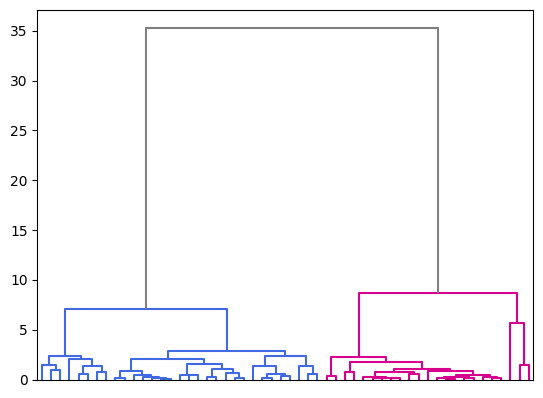

In [74]:
Z = hierarchy.linkage(module_pearson_corr,method= 'average',metric='sqeuclidean')   

hierarchy.set_link_color_palette(["#4169E1",'#D7008C']) 
k = hierarchy.dendrogram(Z,labels = module_pearson_corr.index,no_labels=True,above_threshold_color="grey",color_threshold=10)
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_3/MES_recluster_clustermap_hierarchy.pdf')

In [75]:
'split into t cluster'
gene_cluster = hierarchy.fcluster(Z, t=2, criterion='maxclust')
module_cluster = pd.DataFrame(index= module_pearson_corr.index,columns=['cluster'])
module_cluster['cluster'] = gene_cluster
module_cluster = module_cluster.loc[k['ivl']]


In [77]:
row_color = pd.DataFrame(index=module_cluster.index,columns=['patient','assay'])

pat_list = []
for item in row_color.index:
    pat_list.append(item.split('_cluster')[0])
    
row_color['patient'] = pat_list

dataset_dict = {'SF':'Bhaduri et al, 2020', 'SM':'Johnson et al, 2021', 'MG':'Neftel et al, 2019', 'GS':'Wang et al, 2020', 
'BT':'Couturier et al, 2020','G1':'Richards et al, 2021'}

dataset_list = []
for item in row_color.index:
    if item[:2] in ['SF','SM','MG','GS','BT','G1']:
        if item[:5] == 'BT_S2':
            dataset_list.append('Darmanis et al, 2017')
        else:
            dataset_list.append(dataset_dict[item[:2]])
    else:
        dataset_list.append('Our dataset')


assay_list = []
for item in row_color['patient']:
    if item in ['P186','SM017','SM018']:
        assay_list.append('v3')
    elif item in ['BT_S2','MGH105_smart','MGH115_smart']:
        assay_list.append('smart-seq2')
    else:
        assay_list.append('v2')

row_color['assay'] = assay_list

In [79]:
module_color_dict = {1:'#4169E1',2:'#D7008C'}
row_color['cluster'] = module_cluster['cluster'].map(module_color_dict)

pat_color_dict = {
 'BT338': '#FEB900','BT346': '#FE9B00','BT364': '#FF800F','BT390': '#FD700F',
    
 'BT_S2': '#23BE69',
    
 'GSM4141789': '#A0522D','GSM4141790': '#823B13',
    
 'MGH105_10X': '#AE77FC', 'MGH105_smart': '#AE77FC', 'MGH115_10X': '#995DFC', 'MGH124': '#A129F0', 'MGH143': '#8603CC',
    
 'P62': '#4169E1','P92': '#1F77B4',
    
 'SF11209': '#FBADC5','SF11232': '#E985C2','SF11247': '#D477C2',
    
 'SM017': '#FF3030','SM018': '#E42729',

 'G1003': '#008080'}

dataset_color_dict = {'Bhaduri et al, 2020':'#E378C2', 'Couturier et al, 2020':'#FF800F', 'Darmanis et al, 2017':'#269F69',
                      'Johnson et al, 2021':'#D72729', 'Neftel et al, 2019':'#AA41FC', 'Wang et al, 2020':'#8D574C',
                      'Our dataset':'#1F77B4'}

assay_color_dict = {'v2':'#2184B4','v3':'#FD910F','smart-seq2':'#269F69'}

row_color['patient'] = row_color['patient'].map(pat_color_dict).tolist()
row_color['assay'] = row_color['assay'].map(assay_color_dict).tolist()

In [81]:
'save clustermap'
module_cluster.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES_recluster_hierarchy.csv')

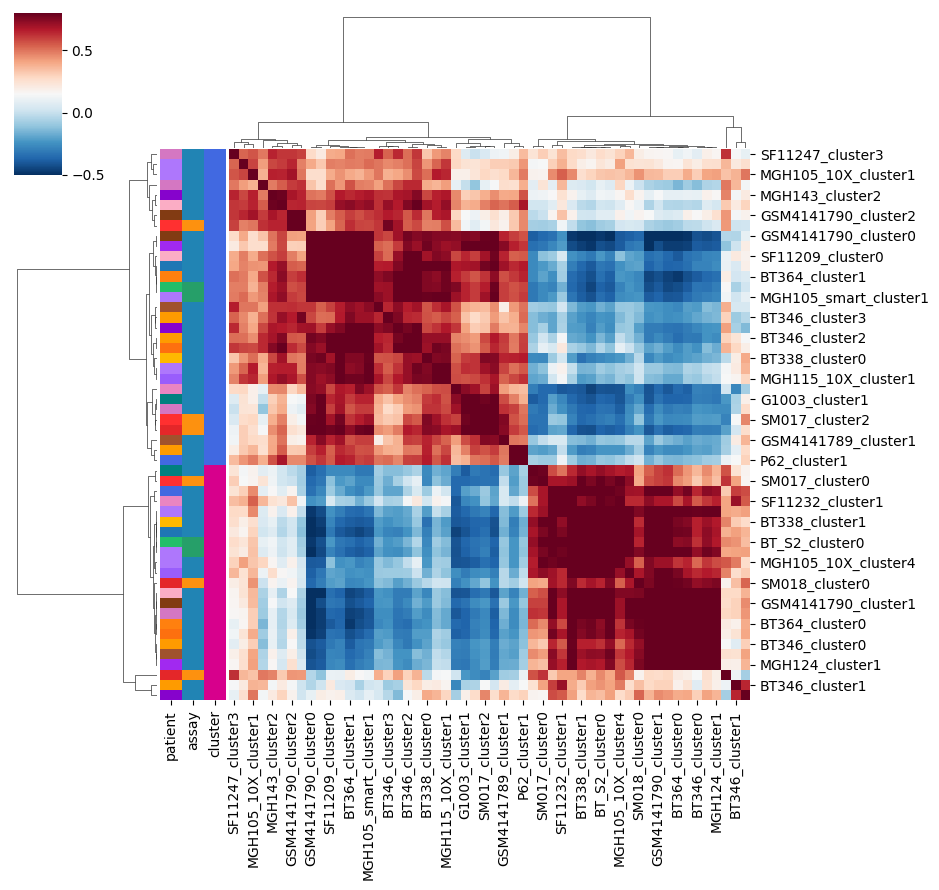

In [82]:
'pearson'
sns.clustermap(module_pearson_corr,cmap='RdBu_r',vmax=0.8,vmin=-0.5,method='average',metric='sqeuclidean',row_colors=row_color,dendrogram_ratio=0.2,figsize=(9.5,9))
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_3/MES_recluster_clustermap.pdf')


In [11]:
'load two type mes cells'
MES1_files = module_cluster.loc[module_cluster['cluster'] == 1].index.tolist()
MES1_files = [ item + '.csv' for item in MES1_files]

MES2_files = module_cluster.loc[module_cluster['cluster'] == 2].index.tolist()
MES2_files = [ item + '.csv' for item in MES2_files]

In [12]:
MES1_gene_panel = []
for item in MES1_files:
    tmp = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + item,index_col=0)['names'].tolist()[:200]
    MES1_gene_panel = MES1_gene_panel + tmp
MES1_gene_panel = list(set(MES1_gene_panel))

MES1_gene_panel_counts = pd.DataFrame(index=MES1_gene_panel,columns=['counts','files'])

In [13]:
def gene_fre_MES1(gene):
    record = 0
    gene_record = []
    for file in MES1_files:
        df = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + file,index_col=0)
        target_genes = df['names'].tolist()[:200]
        if gene in target_genes:
            record = record + 1
            gene_record.append(file.split('.csv')[0])
    return (record, gene_record)

In [14]:
pool = Pool(100)
gene_result = pool.map(gene_fre_MES1, MES1_gene_panel_counts.index.tolist())
pool.close()
pool.join()

In [15]:
MES1_gene_panel_counts['counts'] = [ item[0] for item in gene_result]
MES1_gene_panel_counts['files'] = [ item[1] for item in gene_result]

In [16]:
MES2_gene_panel = []
for item in MES2_files:
    tmp = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + item,index_col=0)['names'].tolist()[:200]
    MES2_gene_panel = MES2_gene_panel + tmp
MES2_gene_panel = list(set(MES2_gene_panel))

In [17]:
MES2_gene_panel_counts = pd.DataFrame(index=MES2_gene_panel,columns=['counts','files'])

In [18]:
def gene_fre_MES2(gene):
    record = 0
    gene_record = []
    for file in MES2_files:
        df = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/sample_DEGs/' + file,index_col=0)
        target_genes = df['names'].tolist()[:200]
        if gene in target_genes:
            record = record + 1
            gene_record.append(file.split('.csv')[0])
    return (record, gene_record)

In [19]:
pool = Pool(100)
gene_result = pool.map(gene_fre_MES2, MES2_gene_panel_counts.index.tolist())
pool.close()
pool.join()

In [20]:
MES2_gene_panel_counts['counts'] = [ item[0] for item in gene_result]
MES2_gene_panel_counts['files'] = [ item[1] for item in gene_result]

In [99]:
MES1_compare = []
for gene in MES1_gene_panel_counts.index:
    if gene not in MES2_gene_panel_counts.index:
        MES1_compare.append(gene)
    elif ( MES1_gene_panel_counts.loc[gene]['counts'] - MES2_gene_panel_counts.loc[gene]['counts'] ) >= 4 :
        MES1_compare.append(gene)
MES1_compare = MES1_gene_panel_counts.loc[MES1_compare]


In [100]:
MES2_compare = []
for gene in MES2_gene_panel_counts.index:
    if gene not in MES1_gene_panel_counts.index:
        MES2_compare.append(gene)
    elif ( MES2_gene_panel_counts.loc[gene]['counts'] - MES1_gene_panel_counts.loc[gene]['counts'] ) >= 3 :
        MES2_compare.append(gene)
MES2_compare = MES2_gene_panel_counts.loc[MES2_compare]


In [101]:
MES1_counts_filter = MES1_compare.loc[ MES1_compare['counts'] >= 4].sort_values('counts',ascending=False)
MES2_counts_filter = MES2_compare.loc[ MES2_compare['counts'] >= 3].sort_values('counts',ascending=False)

In [104]:
MES1_counts_filter.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES1_gene_counts_df.csv')
MES2_counts_filter.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES2_gene_counts_df.csv')

In [105]:
pd.DataFrame(MES1_counts_filter.index).to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES1_gene_name_only.csv',index=False)
pd.DataFrame(MES2_counts_filter.index).to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES2_gene_name_only.csv',index=False)